In [1]:
import pandas as pd
import itertools
import seaborn as sns
from db import get_df, Database
import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_auc_score, roc_curve

%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
from matplotlib import gridspec, pyplot as plt


set_matplotlib_formats('svg')

pd.set_option('display.max_rows', None)

__pcaps = {}

def get_pcaps(slot_h=1.):
    if slot_h in __pcaps:
        return __pcaps[slot_h]
    
    db = Database()

    DF_FP = get_df(db, 'normal', None, True, 'nx', slot_h=slot_h).iloc[0:int(8/slot_h)]

    dfs = {
        'healthy': DF_FP,
        'caphaw': get_df(db, 'caphaw', 54, True, 'nx'),
        'zbot': get_df(db, 'zbot', 46, True, 'nx'),
        'simda': get_df(db, 'simda', 58, True, 'nx'),
        'unknown': get_df(db, 'unknown', 57, True, 'nx'),
    }
    return dfs


In [46]:

tps = np.array([2, 5, 9])  # Array dei true positives
fps = np.array([1, 1, 2])  # Array dei false positives
thresholds = np.array([1,2,5,9])  # Array delle soglie

valid_tps = tps > 0  # Boolean array per tps > 0
total_valid_tps = np.sum(valid_tps)  # Calcola sum(tps > 0) una volta sola

# Broadcasting per calcolare la condizione su ogni threshold
conditions_met = (fps + tps)[:, np.newaxis] >= thresholds  # Forma (n, m)
valid_conditions = (valid_tps[:, np.newaxis] & conditions_met)  # Forma (n, m)

# Calcola la proporzione per ogni threshold
tpar = np.sum(valid_conditions, axis=0) / total_valid_tps

tpar


array([1.        , 1.        , 0.66666667, 0.33333333])

In [2]:

def simulate_pcaps(dfs, slot_h, window_slots, sigma_fp_ratio=1.0, mus_ratios=[0.5,1.0,1.5]):

    res = []
    for mw in dfs:
        if mw == 'healthy':
            continue
        df_tp = dfs[mw]
        skipped_all = 0
        skipped_any = 0
        for w in range(0, int(24*30/slot_h)):
            tps = df_tp.iloc[w:w + window_slots]['pp'].reset_index(drop=True).to_numpy()

            if tps.shape[0] < window_slots:
                break

            for mus_ratio in mus_ratios:
                mu_fp = tps.mean() / mus_ratio
                sigma_fp = mu_fp * sigma_fp_ratio

                fps = np.random.normal(mu_fp, sigma_fp, tps.shape[0])

                labels = tps > 0

                if labels.all() or labels.any() == False:
                    skipped_all += labels.all()
                    skipped_any += labels.any() == False
                    continue

                fpr, tpr, thresholds = roc_curve(labels, (fps + tps), drop_intermediate=False)
                roc_auc = auc(fpr, tpr)

                mask = fpr < 0.01
                pAUCs_001 = roc_auc_score(labels, (fps + tps), max_fpr=0.01)

                # tpa = [ sum(tps > 0) for th in thresholds ]
                # ppa = [ sum((tps > 0) & ((fps + tps) >= th)) for th in
                # thresholds ]# Calcolo in numpy
                valid_tps = tps > 0
                total_valid_tps = np.sum(valid_tps)
                conditions_met = (fps + tps)[:, np.newaxis] >= thresholds
                valid_conditions = (valid_tps[:, np.newaxis] & conditions_met)
                tpar = np.sum(valid_conditions, axis=0) / total_valid_tps

                try:
                    pAUC_001 = auc(fpr[mask], tpr[mask])
                except:
                    pAUC_001 = np.nan
                    pass

                res.append([
                    mw,
                    w,
                    mus_ratio,
                    sigma_fp_ratio,
                    tps.std() / tps.mean(),
                    mu_fp,
                    sigma_fp,
                    tps.mean(),
                    tps.std(),
                    fpr,
                    tpr,
                    # tpa,
                    # ppa,
                    tpar,
                    roc_auc,
                    pAUCs_001,
                    pAUC_001
                ])
                pass
            pass
        pass

    DF = pd.DataFrame(res, columns=[
        'mw',
        'w',
        'mus_ratio',
        'sigma_fp_ratio',
        'sigma_tp_ratio',
        'mu_fp',
        'sigma_fp',
        'mu_tp',
        'sigma_tp',
        'fpr',
        'tpr',
        # 'tpa',
        # 'ppa',
        'tpar',
        'roc_auc',
        'pAUCs_001',
        'pAUC_001'
    ])

    return DF


In [75]:

slot_h = 1
pcaps = get_pcaps(slot_h)
mus_ratios = [0.5,1.0,1.5]
window_slots = 16
N=4
linspace_num_s = [3]
sigma_fp_ratios = [0.1, 0.5, 1, 2, 4]
dfs = []
for repetition in range(N):
    for sigma_fp_ratio in sigma_fp_ratios:
        df = simulate_pcaps(pcaps, slot_h, window_slots, sigma_fp_ratio=sigma_fp_ratio, mus_ratios=mus_ratios)
        dfs.append(df)
        pass

df = pd.concat(dfs, axis=0)

df.to_pickle(f'DF_TPdet__sim{N}.csv')

In [4]:
df = pd.read_pickle(f'DF_TPdet__sim{N}.csv')

intervals = 25

df['mus_ratio_cat'] = pd.CategoricalIndex(df['mus_ratio'])

df['sigma_tp_ratio_cat'] = pd.cut(df['sigma_tp_ratio'], bins=5)
df['sigma_tp_ratio_mid'] = df['sigma_tp_ratio_cat'].apply(lambda x: x.left).astype(np.float64)

# df['sigma_tp_ratio_cat'] = pd.cut(df['sigma_tp_ratio'], bins=pd.IntervalIndex([ pd.Interval(b[0], b[1], closed='right') for b in bins ]))


df['fpr'] = df['fpr'].apply(lambda s: pd.cut(s, bins=pd.IntervalIndex.from_breaks([-.001] + list(map(lambda x: x/intervals, range(1,intervals + 1))), closed='right')))
df['tpr'] = df['tpr'].apply(lambda s: pd.cut(s, bins=pd.IntervalIndex.from_breaks([-.001] + list(map(lambda x: x/intervals, range(1,intervals + 1))), closed='right')))

intervals = 4

# df['tpa'] = df['fpa'].apply(lambda s: pd.cut(s, bins=pd.IntervalIndex.from_breaks([-.001] + list(map(lambda x: x/intervals, range(1,intervals + 1))), closed='right')))
# df['tpa'] = df['tpa'].apply(lambda s: pd.cut(s,
# bins=pd.IntervalIndex.from_breaks([-.001] + list(map(lambda x: x/intervals,
# range(1,intervals + 1))), closed='right')))
idx = pd.IntervalIndex.from_breaks([-.001, 0.01, 0.5, 1.0], closed='right')

# df['tpar'] = df['tpar'].apply(lambda s: s == 0)
df['tpar'] = df['tpar'].apply(lambda s: pd.cut(s, bins=idx))

df = df.explode(['fpr', 'tpr', 'tpar'])

df.fpr = df.fpr.apply(lambda x: x.mid)
df.tpr = df.tpr.apply(lambda x: x.mid)
# df.tpar = df.tpar.apply(lambda x: x.mid)


KeyboardInterrupt: 

In [26]:
df = pd.read_pickle(f'DF_TPdet__sim{N}.csv')

df['mus_ratio_cat'] = pd.CategoricalIndex(df['mus_ratio'])
df['sigma_tp_ratio_cat'] = pd.cut(df['sigma_tp_ratio'], bins=5)
df['sigma_tp_ratio_mid'] = df['sigma_tp_ratio_cat'].apply(lambda x: x.left).astype(np.float64)

intervals = 25
idx = pd.IntervalIndex.from_breaks([-.001] + list(map(lambda x: x/intervals, range(1,intervals + 1))), closed='right')
df['fpr'] = df['fpr'].apply(lambda s: pd.cut(s, bins=idx))
df['tpr'] = df['tpr'].apply(lambda s: pd.cut(s, bins=idx))

intervals = 4
idx = pd.IntervalIndex.from_breaks([-.001, 0.01, 0.5, 1.0], closed='right')
df['tpar'] = df['tpar'].apply(lambda s: pd.cut(s, bins=idx))

df = df.explode(['fpr', 'tpr', 'tpar'])

df.fpr = df.fpr.apply(lambda x: x.mid)
df.tpr = df.tpr.apply(lambda x: x.mid)

DF = df.copy()

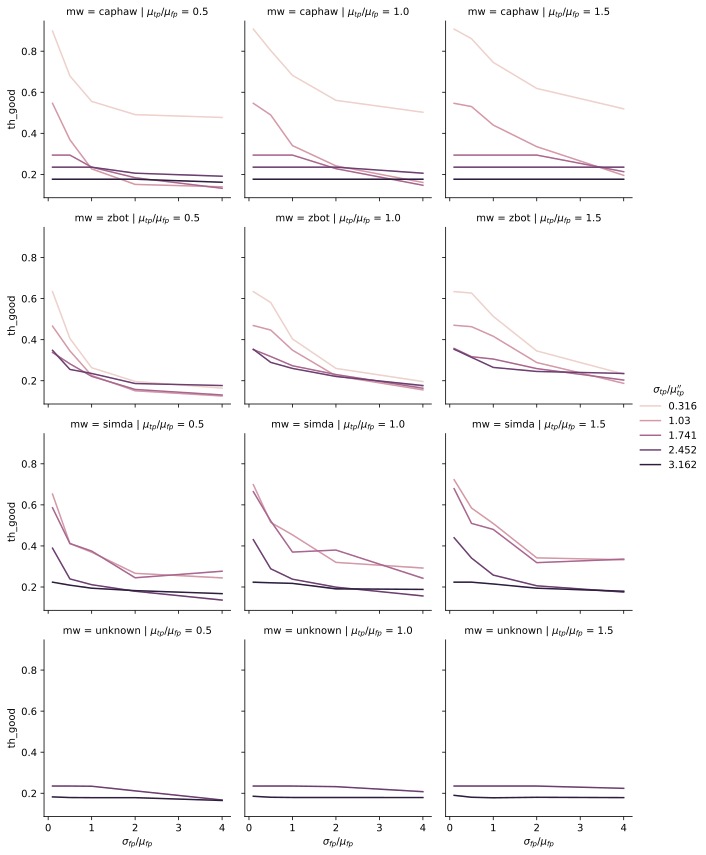

In [24]:

df['ths'] = 1
df['th_good'] = 1
df['th_good'] = df['th_good'].where((df['fpr'] < 0.1) & (df['tpr'] > 0), 0)


th_good = df[['th_good', 'ths', 'mw', 'sigma_tp_ratio_mid', 'mus_ratio_cat', 'sigma_fp_ratio']].groupby(['mw', 'sigma_tp_ratio_mid', 'mus_ratio_cat', 'sigma_fp_ratio']).sum()

th_good = (th_good['th_good'] / th_good['ths']).dropna().reset_index()

g = sns.relplot(th_good.rename(columns=renamer),
                x=renamer['sigma_fp_ratio'], y='th_good',
                hue=renamer['sigma_tp_ratio_mid'],
                col=renamer['mus_ratio_cat'],
                row='mw',
                # style='tpar',
                # markers=True,
                # dashes=False,
                errorbar=('ci', 0.9),
                kind='line',
                height=3,
                # facet_kws=dict(sharey=False, sharex=False)
)

/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_61824/1979720785.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_th = df[th_goods + ['ths', 'mw', 'sigma_tp_ratio', 'mus_ratio_cat', 'sigma_fp_ratio']].groupby([ 'mw', 'sigma_tp_ratio', 'mus_ratio_cat', 'sigma_fp_ratio']).sum().dropna()


(0.01, 0)                 (0.01, 0.5)  \
sigma_fp_ratio                             0.1 0.5 1.0 2.0 4.0         0.1   
mw      sigma_tp_ratio mus_ratio_cat                                         
caphaw  0.316          0.5                  83  60  49  43  41          42   
                       1.0                  85  71  60  49  44          45   
                       1.5                  85  77  66  54  45          45   
        1.030          0.5                  49  31  17   9   8          27   
                       1.0                  49  44  28  18  10          27   
                       1.5                  49  47  38  28  14          27   
        1.741          0.5                  21  21  14   9   4          12   
                       1.0                  21  21  21  12   6          12   
                       1.5                  21  21  21  21  12          12   
        2.452          0.5                  12  12  12   6   6           6   
                       1.0                  12  12  12  12   6           6   
                       1.5                  12  12  12  12  12           6   
        3.162          0.5                   6   6   6   6   3           6   
                       1.0                   6   6   6   6   6           6   
                       1.5                   6   6   6   6   6           6   
simda   1.030          0.5                  59  35  30  21  19          26   
                       1.0                  62  46  38  26  22          28   
                       1.5                  69  53  44  28  27          35   
        1.741          0.5                  53  35  32  19  22          21   
                       1.0                  61  41  31  30  18          28   
                       1.5                  68  45  40  26  28          33   
        2.452          0.5                  35  18  14  11   7          14   
                       1.0                  44  23  17  13   9          22   
                       1.5                  44  28  20  14  11          23   
        3.162          0.5                  11   8   7   5   3           7   
                       1.0                  11  11  10   8   7           7   
                       1.5                  11  11   9   8   6           7   
unknown 2.452          0.5                  12  12  10   7   3           6   
                       1.0                  12  12  12  10   6           6   
                       1.5                  12  12  12  12   8           6   
        3.162          0.5                   6   6   6   6   3           3   
                       1.0                   7   6   6   6   6           4   
                       1.5                   7   6   6   6   6           4   
zbot    0.316          0.5                  57  35  20  14  11          30   
                       1.0                  57  51  34  20  14          30   
                       1.5                  57  56  44  28  17          30   
        1.030          0.5                  41  28  17   9   7          21   
                       1.0                  42  38  28  16  10          22   
                       1.5                  42  40  35  23  13          22   
        1.741          0.5                  28  21  14   8   6          13   
                       1.0                  30  26  19  15   9          16   
                       1.5                  33  26  23  18  12          18   
        2.452          0.5                  28  17  13   8   6          15   
                       1.0                  25  24  18  10   7          14   
                       1.5                  25  28  19  14  12          14   

                                                     (0.01, 0.9)              \
sigma_fp_ratio                       0.5 1.0 2.0 4.0         0.1 0.5 1.0 2.0   
mw      sigma_tp_ratio mus_ratio_cat                                           
caphaw  0.316          0.5            23  16  12  12

(900, 6)


/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_61824/1979720785.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_th = df[th_goods + ['ths', 'mw', 'sigma_tp_ratio', 'mus_ratio_cat', 'sigma_fp_ratio']].groupby([ 'mw', 'sigma_tp_ratio', 'mus_ratio_cat', 'sigma_fp_ratio']).sum().dropna()


(0.01, 0)                 (0.01, 0.5)  \
sigma_fp_ratio                             0.1 0.5 1.0 2.0 4.0         0.1   
mw      sigma_tp_ratio mus_ratio_cat                                         
caphaw  0.316          0.5                  83  60  49  43  41          42   
                       1.0                  85  71  60  49  44          45   
                       1.5                  85  77  66  54  45          45   
        1.030          0.5                  49  31  17   9   8          27   
                       1.0                  49  44  28  18  10          27   
                       1.5                  49  47  38  28  14          27   
        1.741          0.5                  21  21  14   9   4          12   
                       1.0                  21  21  21  12   6          12   
                       1.5                  21  21  21  21  12          12   
        2.452          0.5                  12  12  12   6   6           6   
                       1.0                  12  12  12  12   6           6   
                       1.5                  12  12  12  12  12           6   
        3.162          0.5                   6   6   6   6   3           6   
                       1.0                   6   6   6   6   6           6   
                       1.5                   6   6   6   6   6           6   
simda   1.030          0.5                  59  35  30  21  19          26   
                       1.0                  62  46  38  26  22          28   
                       1.5                  69  53  44  28  27          35   
        1.741          0.5                  53  35  32  19  22          21   
                       1.0                  61  41  31  30  18          28   
                       1.5                  68  45  40  26  28          33   
        2.452          0.5                  35  18  14  11   7          14   
                       1.0                  44  23  17  13   9          22   
                       1.5                  44  28  20  14  11          23   
        3.162          0.5                  11   8   7   5   3           7   
                       1.0                  11  11  10   8   7           7   
                       1.5                  11  11   9   8   6           7   
unknown 2.452          0.5                  12  12  10   7   3           6   
                       1.0                  12  12  12  10   6           6   
                       1.5                  12  12  12  12   8           6   
        3.162          0.5                   6   6   6   6   3           3   
                       1.0                   7   6   6   6   6           4   
                       1.5                   7   6   6   6   6           4   
zbot    0.316          0.5                  57  35  20  14  11          30   
                       1.0                  57  51  34  20  14          30   
                       1.5                  57  56  44  28  17          30   
        1.030          0.5                  41  28  17   9   7          21   
                       1.0                  42  38  28  16  10          22   
                       1.5                  42  40  35  23  13          22   
        1.741          0.5                  28  21  14   8   6          13   
                       1.0                  30  26  19  15   9          16   
                       1.5                  33  26  23  18  12          18   
        2.452          0.5                  28  17  13   8   6          15   
                       1.0                  25  24  18  10   7          14   
                       1.5                  25  28  19  14  12          14   

                                                     (0.01, 0.9)              \
sigma_fp_ratio                       0.5 1.0 2.0 4.0         0.1 0.5 1.0 2.0   
mw      sigma_tp_ratio mus_ratio_cat                                           
caphaw  0.316          0.5            23  16  12  12

(900, 6)


/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_61824/1979720785.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_th = df[th_goods + ['ths', 'mw', 'sigma_tp_ratio', 'mus_ratio_cat', 'sigma_fp_ratio']].groupby([ 'mw', 'sigma_tp_ratio', 'mus_ratio_cat', 'sigma_fp_ratio']).sum().dropna()


(0.01, 0)                 (0.01, 0.5)  \
sigma_fp_ratio                             0.1 0.5 1.0 2.0 4.0         0.1   
mw      sigma_tp_ratio mus_ratio_cat                                         
caphaw  0.316          0.5                  83  60  49  43  41          42   
                       1.0                  85  71  60  49  44          45   
                       1.5                  85  77  66  54  45          45   
        1.030          0.5                  49  31  17   9   8          27   
                       1.0                  49  44  28  18  10          27   
                       1.5                  49  47  38  28  14          27   
        1.741          0.5                  21  21  14   9   4          12   
                       1.0                  21  21  21  12   6          12   
                       1.5                  21  21  21  21  12          12   
        2.452          0.5                  12  12  12   6   6           6   
                       1.0                  12  12  12  12   6           6   
                       1.5                  12  12  12  12  12           6   
        3.162          0.5                   6   6   6   6   3           6   
                       1.0                   6   6   6   6   6           6   
                       1.5                   6   6   6   6   6           6   
simda   1.030          0.5                  59  35  30  21  19          26   
                       1.0                  62  46  38  26  22          28   
                       1.5                  69  53  44  28  27          35   
        1.741          0.5                  53  35  32  19  22          21   
                       1.0                  61  41  31  30  18          28   
                       1.5                  68  45  40  26  28          33   
        2.452          0.5                  35  18  14  11   7          14   
                       1.0                  44  23  17  13   9          22   
                       1.5                  44  28  20  14  11          23   
        3.162          0.5                  11   8   7   5   3           7   
                       1.0                  11  11  10   8   7           7   
                       1.5                  11  11   9   8   6           7   
unknown 2.452          0.5                  12  12  10   7   3           6   
                       1.0                  12  12  12  10   6           6   
                       1.5                  12  12  12  12   8           6   
        3.162          0.5                   6   6   6   6   3           3   
                       1.0                   7   6   6   6   6           4   
                       1.5                   7   6   6   6   6           4   
zbot    0.316          0.5                  57  35  20  14  11          30   
                       1.0                  57  51  34  20  14          30   
                       1.5                  57  56  44  28  17          30   
        1.030          0.5                  41  28  17   9   7          21   
                       1.0                  42  38  28  16  10          22   
                       1.5                  42  40  35  23  13          22   
        1.741          0.5                  28  21  14   8   6          13   
                       1.0                  30  26  19  15   9          16   
                       1.5                  33  26  23  18  12          18   
        2.452          0.5                  28  17  13   8   6          15   
                       1.0                  25  24  18  10   7          14   
                       1.5                  25  28  19  14  12          14   

                                                     (0.01, 0.9)              \
sigma_fp_ratio                       0.5 1.0 2.0 4.0         0.1 0.5 1.0 2.0   
mw      sigma_tp_ratio mus_ratio_cat                                           
caphaw  0.316          0.5            23  16  12  12

(900, 6)


/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_61824/1979720785.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_th = df[th_goods + ['ths', 'mw', 'sigma_tp_ratio', 'mus_ratio_cat', 'sigma_fp_ratio']].groupby([ 'mw', 'sigma_tp_ratio', 'mus_ratio_cat', 'sigma_fp_ratio']).sum().dropna()


(0.01, 0)                 (0.01, 0.5)  \
sigma_fp_ratio                             0.1 0.5 1.0 2.0 4.0         0.1   
mw      sigma_tp_ratio mus_ratio_cat                                         
caphaw  0.316          0.5                  83  60  49  43  41          42   
                       1.0                  85  71  60  49  44          45   
                       1.5                  85  77  66  54  45          45   
        1.030          0.5                  49  31  17   9   8          27   
                       1.0                  49  44  28  18  10          27   
                       1.5                  49  47  38  28  14          27   
        1.741          0.5                  21  21  14   9   4          12   
                       1.0                  21  21  21  12   6          12   
                       1.5                  21  21  21  21  12          12   
        2.452          0.5                  12  12  12   6   6           6   
                       1.0                  12  12  12  12   6           6   
                       1.5                  12  12  12  12  12           6   
        3.162          0.5                   6   6   6   6   3           6   
                       1.0                   6   6   6   6   6           6   
                       1.5                   6   6   6   6   6           6   
simda   1.030          0.5                  59  35  30  21  19          26   
                       1.0                  62  46  38  26  22          28   
                       1.5                  69  53  44  28  27          35   
        1.741          0.5                  53  35  32  19  22          21   
                       1.0                  61  41  31  30  18          28   
                       1.5                  68  45  40  26  28          33   
        2.452          0.5                  35  18  14  11   7          14   
                       1.0                  44  23  17  13   9          22   
                       1.5                  44  28  20  14  11          23   
        3.162          0.5                  11   8   7   5   3           7   
                       1.0                  11  11  10   8   7           7   
                       1.5                  11  11   9   8   6           7   
unknown 2.452          0.5                  12  12  10   7   3           6   
                       1.0                  12  12  12  10   6           6   
                       1.5                  12  12  12  12   8           6   
        3.162          0.5                   6   6   6   6   3           3   
                       1.0                   7   6   6   6   6           4   
                       1.5                   7   6   6   6   6           4   
zbot    0.316          0.5                  57  35  20  14  11          30   
                       1.0                  57  51  34  20  14          30   
                       1.5                  57  56  44  28  17          30   
        1.030          0.5                  41  28  17   9   7          21   
                       1.0                  42  38  28  16  10          22   
                       1.5                  42  40  35  23  13          22   
        1.741          0.5                  28  21  14   8   6          13   
                       1.0                  30  26  19  15   9          16   
                       1.5                  33  26  23  18  12          18   
        2.452          0.5                  28  17  13   8   6          15   
                       1.0                  25  24  18  10   7          14   
                       1.5                  25  28  19  14  12          14   

                                                     (0.01, 0.9)              \
sigma_fp_ratio                       0.5 1.0 2.0 4.0         0.1 0.5 1.0 2.0   
mw      sigma_tp_ratio mus_ratio_cat                                           
caphaw  0.316          0.5            23  16  12  12

(900, 6)


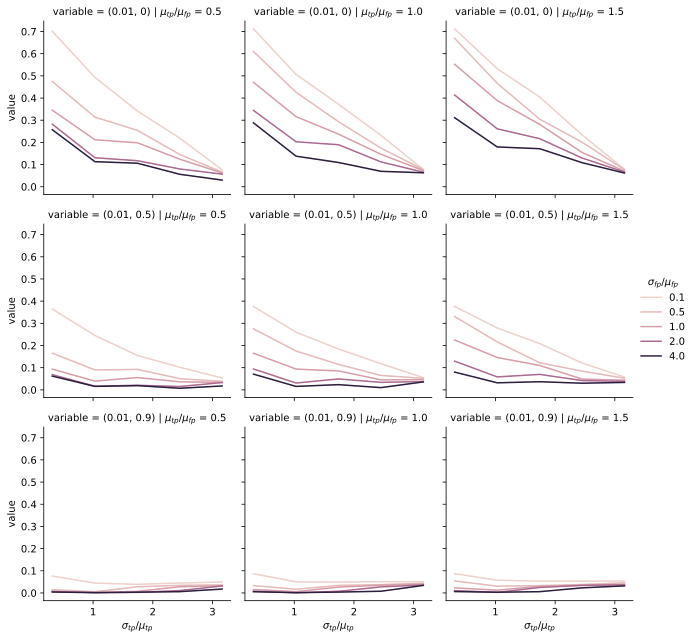

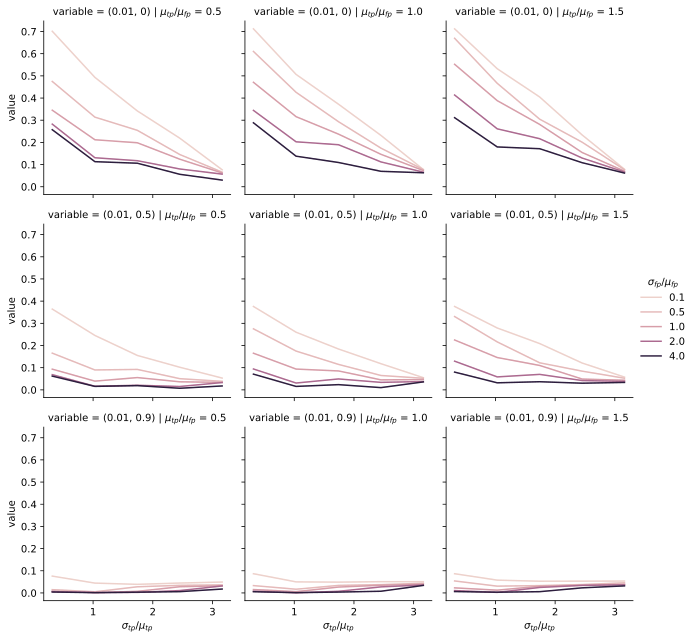

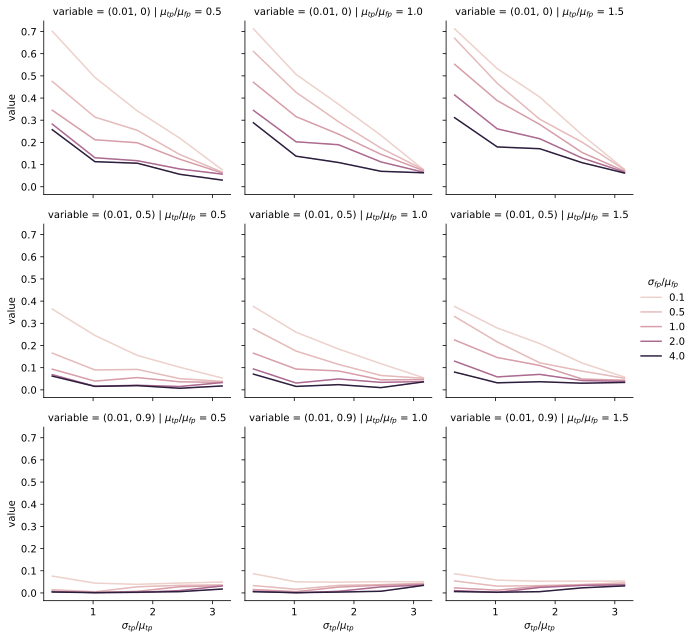

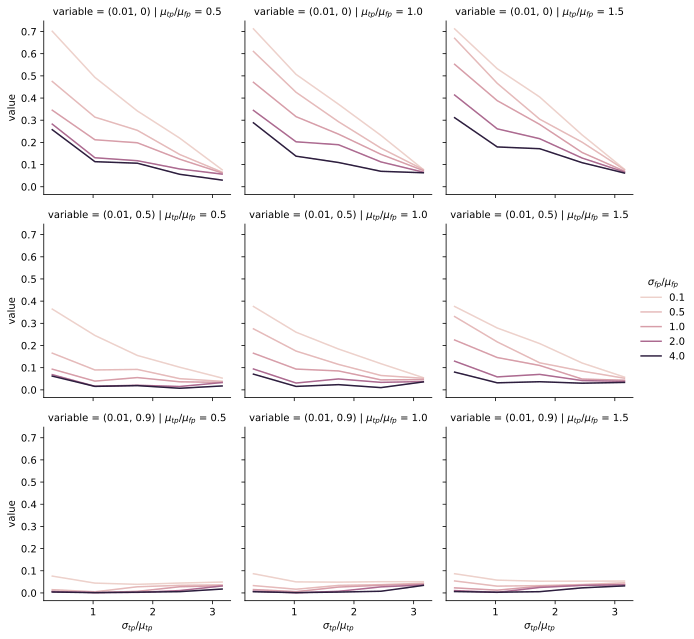

In [33]:
df = pd.read_pickle(f'DF_TPdet__sim{N}.csv')

intervals = 25

df['mus_ratio_cat'] = pd.CategoricalIndex(df['mus_ratio'])
df['sigma_tp_ratio_cat'] = pd.cut(df['sigma_tp_ratio'], bins=5)
df['sigma_tp_ratio'] = df['sigma_tp_ratio_cat'].apply(lambda x: x.left).astype(np.float64)

df['fpr'] = df['fpr'].apply(lambda s: pd.cut(s, bins=pd.IntervalIndex.from_breaks([-.001] + list(map(lambda x: x/intervals, range(1,intervals + 1))), closed='right')))
df['tpr'] = df['tpr'].apply(lambda s: pd.cut(s, bins=pd.IntervalIndex.from_breaks([-.001] + list(map(lambda x: x/intervals, range(1,intervals + 1))), closed='right')))

intervals = 4
idx = pd.IntervalIndex.from_breaks([-.001, 0.01, 0.5, 1.0], closed='right')
df['tpar'] = df['tpar'].apply(lambda s: pd.cut(s, bins=idx))

df = df.explode(['fpr','tpr', 'tpar'])

df.fpr = df.fpr.apply(lambda x: x.left)
df.tpr = df.tpr.apply(lambda x: x.left)

df = df.drop_duplicates()

for mw in df.mw.drop_duplicates():

    th_goods = []
    df['ths'] = 1
    for fp_th, tp_th in itertools.product([0.01], (0, 0.5, 0.9)):
        col = f'({fp_th}, {tp_th})'
        df[col] = 1
        df[col] = df[col].where((df['fpr'] < fp_th) & (df['tpr'] > tp_th), 0)
        th_goods.append(col)
        pass


    df_th = df[th_goods + ['ths', 'mw', 'sigma_tp_ratio', 'mus_ratio_cat', 'sigma_fp_ratio']].groupby([ 'mw', 'sigma_tp_ratio', 'mus_ratio_cat', 'sigma_fp_ratio']).sum().dropna()

    for col in th_goods:
        df_th[col] = (df_th[col] / df_th['ths'])
        pass


    display((df_th.dropna().drop(columns='ths').unstack().round(2) * 100).astype(int))

    df_th = df_th.reset_index().melt(id_vars='mw,sigma_tp_ratio,mus_ratio_cat,sigma_fp_ratio'.split(','), value_vars=th_goods)
    print(df_th.shape)

    df_th['fpr_th'] = df_th['variable'].apply(lambda x: x[1:].split(',')[0])
    df_th['tpr_th'] = df_th['variable'].apply(lambda x: x[1:-1].split(',')[1])

    g = sns.relplot(df_th.rename(columns=renamer),
                    y='value',
                    x=renamer['sigma_tp_ratio'],
                    hue=renamer['sigma_fp_ratio'],
                    col=renamer['mus_ratio_cat'],
                    # col='tpr_th',
                    row='variable',
                    # style='tpar',
                    # markers=True,
                    # dashes=False,
                    errorbar=('ci', 0.9),
                    kind='line',
                    height=3,
                    # facet_kws=dict(sharey=False, sharex=False)
    )


In [21]:
renamer = {
    'sigma_fp_ratio': '$\\sigma_{fp}/\\mu_{fp}$',
    'sigma_fp_ratio_cat': '$\\sigma_{fp}/\\mu_{fp}\'$',
    'sigma_tp_ratio': '$\\sigma_{tp}/\\mu_{tp}$',
    'sigma_tp_ratio_cat': '$\\sigma_{tp}/\\mu_{tp}\'$',
    'sigma_tp_ratio_mid': '$\\sigma_{tp}/\\mu_{tp}\'\'$',
    'mus_ratio_cat': '$\\mu_{tp}/\\mu_{fp}$'
}

In [29]:

for mw in df.mw.drop_duplicates():
    g = sns.relplot(df[df.mw == mw].rename(columns=renamer),
                    x='fpr', y='tpr',
                    hue=renamer['sigma_tp_ratio_mid'],
                    row=renamer['mus_ratio_cat'],
                    col=renamer['sigma_fp_ratio'],
                    # style='tpar',
                    # markers=True,
                    # dashes=False,
                    errorbar=('ci', 0.9),
                    kind='line',
                    height=3,
                    # facet_kws=dict(sharey=False, sharex=False)
                    )

    rows = g.axes.shape[0]
    cols = g.axes.shape[1]

    [ g.axes[i,0].set_ylabel(g.axes[i,0].title.get_text().split('|')[0] + '\ntpr') for i in range(rows) ]
    [ g.axes[0,j].set_title(g.axes[0,j].title.get_text().split('|')[1], size='medium') for j in range(cols) ]
    [ g.axes[i,j].set_title('') for i in range(1,rows) for j in range(cols) ]
    [ g.axes[i,j].grid(True, axis='both', linestyle='--', color='lightgray') for i in range(rows) for j in range(cols) ]
    [ g.axes[i,j].set_yticks(list(map(lambda x: x/5, range(6)))) for i in range(rows) for j in range(cols) ]
    [ g.axes[i,j].set_xticks(list(map(lambda x: x/20, range(6)))) for i in range(rows) for j in range(cols) ]
    [ g.axes[i,j].tick_params(axis="x", direction="in", pad=-12, labelsize='small', labelcolor='gray') for i in range(rows) for j in range(cols) ]
    [ g.axes[i,j].tick_params(axis="y", direction="in", labeltop=True, pad=-20, labelsize='small', labelcolor='gray') for i in range(rows) for j in range(cols) ]
    [ g.axes[i,j].set_ylim(-0.1, 1.05) for i in range(rows) for j in range(cols) ]
    [ g.axes[i,j].set_xlim(-0.04, 0.26) for i in range(rows) for j in range(cols) ]
    # [ g.axes[i,j].scatter() for i in range(rows) for j in range(cols) ]


    plt.gcf().subplots_adjust(hspace=0.1, wspace=0.1)

    plt.gcf().savefig(f'beamer/det_{mw}.pdf')
    
    break
    pass
pass

/Users/princio/Repo/princio/malware-detection-predict-file/venv/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 99.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/princio/Repo/princio/malware-detection-predict-file/venv/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 91.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/princio/Repo/princio/malware-detection-predict-file/venv/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 93.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/princio/Repo/princio/malware-detection-predict-file/venv/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 98.3% of the points cannot be placed; you m

KeyboardInterrupt: 

: 

: 

In [62]:
def neg_rp(mu, sigma):
    try:
        _r = pow(mu,2)/(pow(sigma,2) - mu)
        _p = mu/pow(sigma,2)
        # print(f'{_r > 0 and (_p >= 0 and _p <=1)}\tmu={mu}\tsimga={sigma}\t_r={_r}\t_p={_p}')
        return _r, _p
    except:
        return neg_rp(mu - 1, sigma)

res = []
for mu, sigma_ratio in itertools.product([5, 50, 100], map(lambda x: x/10 + 0.5, range(1,10))):
    sigma = mu*sigma_ratio
    _r, _p= neg_rp(mu, sigma)
    res.append([
        mu, sigma, sigma_ratio, _r, _p
    ])

df = pd.DataFrame(res, columns='mu,sigma,sigma_ratio,_r,_p'.split(','))
print(all(df['_r'] > 0), all(df['_p'].between(0,1, inclusive='both')))
display(df)

True True


,mu,sigma,sigma_ratio,_r,_p
0,5,3.0,0.6,6.250000,0.555556
1,5,3.5,0.7,3.448276,0.408163
2,5,4.0,0.8,2.272727,0.312500
3,5,4.5,0.9,1.639344,0.246914
4,5,5.0,1.0,1.250000,0.200000
5,5,5.5,1.1,0.990099,0.165289
6,5,6.0,1.2,0.806452,0.138889
7,5,6.5,1.3,0.671141,0.118343
8,5,7.0,1.4,0.568182,0.102041
9,50,30.0,0.6,2.941176,0.055556
